[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Average Word Count: 37.84745
Class Distribution:
 Class
3    0.25
4    0.25
2    0.25
1    0.25
Name: proportion, dtype: float64
Vocabulary Size: 61165


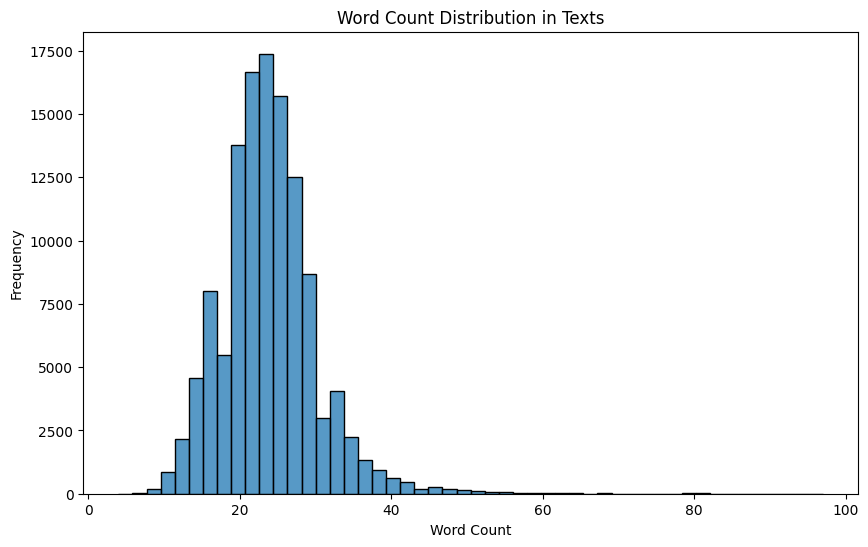

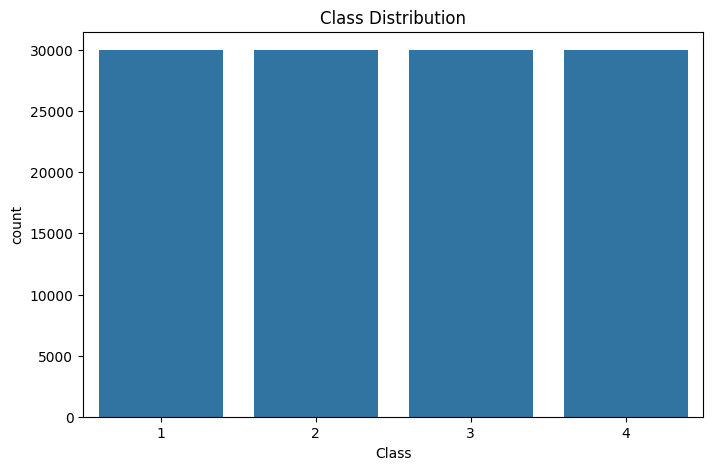

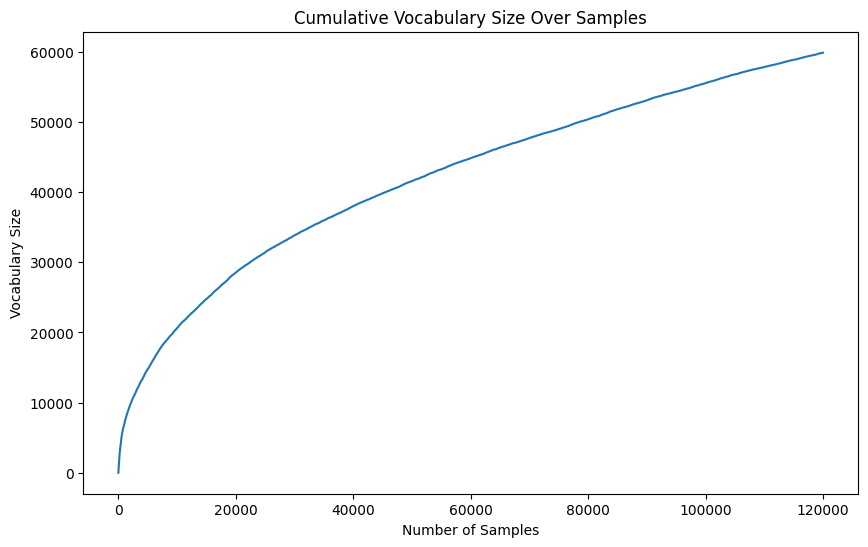

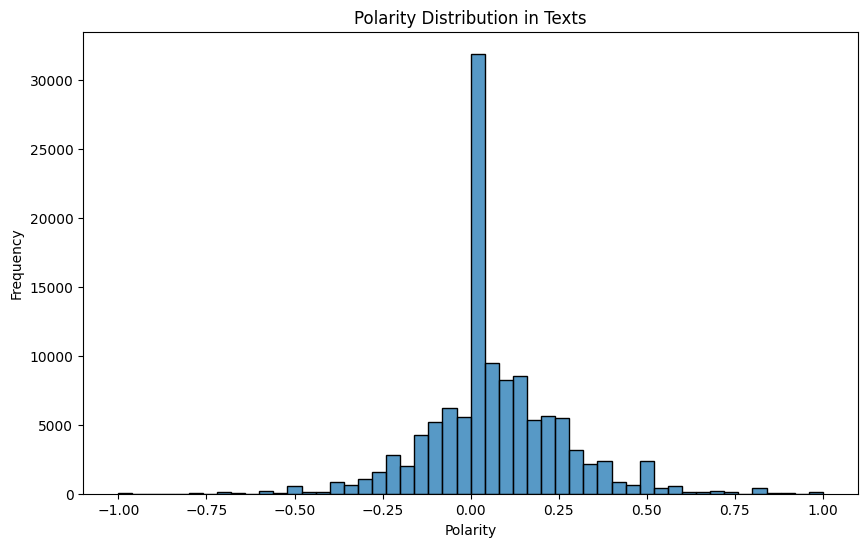

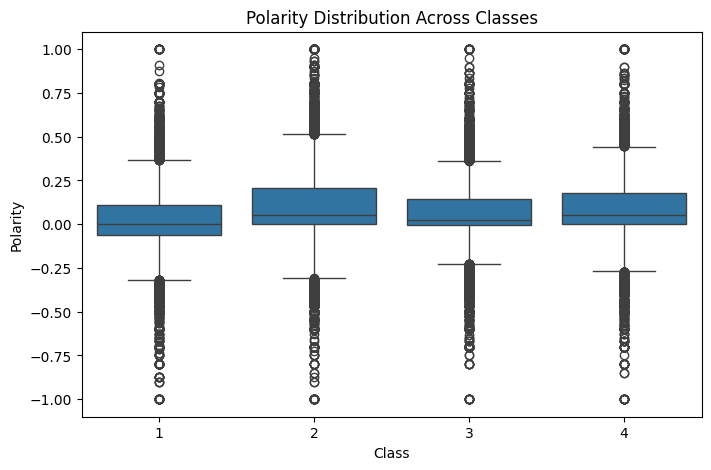

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from textblob import TextBlob

# Downloading NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')

# Loading training and testing data
train_data = pd.read_csv('/content/train.csv', header=None, names=['Label', 'Title', 'Description'])
test_data = pd.read_csv('/content/test.csv', header=None, names=['Label', 'Title', 'Description'])

# Concatenating title and description into a single text column
train_data['Full_Text'] = train_data['Title'] + ' ' + train_data['Description']
test_data['Full_Text'] = test_data['Title'] + ' ' + test_data['Description']

# Printing statistics to understand the dataset better
print("Average Word Count:", np.mean(train_data['Full_Text'].apply(lambda x: len(x.split()))))
print("Label Distribution:\n", train_data['Label'].value_counts(normalize=True))

# Function to preprocess text: remove non-alpha characters, stopwords, and convert to lower case
stop_words = set(stopwords.words('english'))

def clean_text(text):
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    return filtered_words

train_data['Processed_Text'] = train_data['Full_Text'].apply(clean_text)
test_data['Processed_Text'] = test_data['Full_Text'].apply(clean_text)

# Building a vocabulary from the processed text
all_words = [word for text in pd.concat([train_data['Processed_Text'], test_data['Processed_Text']]) for word in text]
unique_words = set(all_words)
print(f"Vocabulary Size: {len(unique_words)}")

# Adding sentiment analysis using TextBlob
train_data['Sentiment_Polarity'] = train_data['Full_Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Visualization of Word Count Distribution
plt.figure(figsize=(10, 6))
sns.histplot([len(text) for text in train_data['Processed_Text']], bins=50)
plt.title('Distribution of Word Counts in Texts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Visualization of Label Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Label', data=train_data)
plt.title('Distribution of Labels')
plt.show()

# Visualization of Cumulative Vocabulary Growth
vocabulary_accumulation = set()
vocabulary_growth = []
for text in train_data['Processed_Text']:
    vocabulary_accumulation.update(text)
    vocabulary_growth.append(len(vocabulary_accumulation))
plt.figure(figsize=(10, 6))
plt.plot(vocabulary_growth)
plt.title('Growth of Vocabulary Over Text Samples')
plt.xlabel('Number of Text Samples')
plt.ylabel('Vocabulary Size')
plt.show()

# Visualization of Sentiment Polarity Distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Sentiment_Polarity'], bins=50)
plt.title('Distribution of Sentiment Polarity in Texts')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Visualization of Sentiment Polarity by Label
plt.figure(figsize=(8, 5))
sns.boxplot(x='Label', y='Sentiment_Polarity', data=train_data)
plt.title('Sentiment Polarity Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Sentiment Polarity')
plt.show()

# Training a Word2Vec model on the combined tokens from training and testing datasets
combined_texts = pd.concat([train_data['Processed_Text'], test_data['Processed_Text']]).tolist()
word2vec = Word2Vec(sentences=combined_texts, vector_size=100, window=5, min_count=1, workers=4)

# Creating document vectors by averaging Word2Vec vectors for words in each document
def create_document_vector(model, document):
    valid_words = [word for word in document if word in model.wv]
    if not valid_words:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[valid_words], axis=0)

train_data['Document_Vector'] = train_data['Processed_Text'].apply(lambda x: create_document_vector(word2vec, x))

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Defining label encoding for categorical data transformation
label_encoder = LabelEncoder()
train_df['Class'] = label_encoder.fit_transform(train_df['Class'])
test_df['Class'] = label_encoder.transform(test_df['Class'])

# Function to create a vocabulary mapping from tokens to indices
def build_vocab(texts):
    words = set(token for text in texts for token in text.split())
    return {word: index for index, word in enumerate(words)}

# Building vocabulary from training and testing texts
vocab_dict = build_vocab(train_df['Text'].tolist() + test_df['Text'].tolist())

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocabulary):
        self.texts = texts
        self.labels = labels
        self.vocabulary = vocabulary

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        # Convert text to indices based on vocabulary
        text_indices = [self.vocabulary[token] for token in text.split()]
        # Transform to tensors
        text_tensor = torch.tensor(text_indices, dtype=torch.long)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return text_tensor, label_tensor

# Function to split data and create datasets
def create_datasets(dataframe, vocabulary, split_ratio=0.2):
    texts = dataframe['Text'].tolist()
    labels = dataframe['Class'].tolist()
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=split_ratio, random_state=42)
    train_dataset = TextDataset(X_train, y_train, vocabulary)
    validation_dataset = TextDataset(X_test, y_test, vocabulary)
    return train_dataset, validation_dataset

# Preparing datasets
training_dataset, validation_dataset = create_datasets(train_df, vocab_dict, split_ratio=0.1)
testing_dataset = TextDataset(test_df['Text'].tolist(), test_df['Class'].tolist(), vocab_dict)

batch_size = 32
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(testing_dataset, batch_size=batch_size)


In [5]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp


class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=2, num_encoder_layers=2, embedding_dim=100):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.output_layer = nn.Linear(embedding_dim, num_classes)

    def forward(self, src):
        src = torch.nn.utils.rnn.pad_sequence(src, batch_first=True)
        embedded = self.embedding(src)
        encoder_output = self.transformer_encoder(embedded)
        output = self.output_layer(encoder_output.mean(dim=1))
        return output


input_dim = len(vocab)
num_classes = len(set(train_df['Class']))
model = TransformerModel(input_dim, num_classes)

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss, total_accuracy = 0, 0
    all_labels = []
    all_preds = []
    all_probabilities = []
    with torch.no_grad():
        for batch in data_loader:
            texts, labels = zip(*batch)
            texts = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True)
            labels = torch.tensor(labels)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_accuracy += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            all_probabilities.append(probabilities)

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = total_accuracy / len(data_loader.dataset)
    all_probabilities = torch.cat(all_probabilities, dim=0)
    return avg_loss, avg_accuracy, all_labels, all_preds, all_probabilities

def plot_metrics(metrics, title):
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train'], label='Train')
    plt.plot(metrics['val'], label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(title.split()[0])
    plt.legend()
    plt.show()

# Modifying the train function to include evaluation on the test set
def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs=2):
    train_acc, train_loss = [], []
    val_acc, val_loss = [], []
    for epoch in range(epochs):
        model.train()
        total_loss, total_accuracy = 0, 0
        for batch in train_loader:
            texts, labels = zip(*batch)
            texts = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True)
            labels = torch.tensor(labels)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_accuracy += (predicted == labels).sum().item()
        train_loss.append(total_loss / len(train_loader))
        train_acc.append(total_accuracy / len(train_loader.dataset))

        # val_loss_epoch, val_acc_epoch, _, _ = evaluate(model, val_loader, criterion)
        val_loss_epoch, val_acc_epoch, _, _, _ = evaluate(model, val_loader, criterion)

        val_loss.append(val_loss_epoch)
        val_acc.append(val_acc_epoch)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Train Accuracy: {train_acc[-1]}, Validation Loss: {val_loss[-1]}, Validation Accuracy: {val_acc[-1]}')

    # Plotting training and validation accuracy and loss
    plot_metrics({'train': train_acc, 'val': val_acc}, 'Accuracy Over Epochs')
    plot_metrics({'train': train_loss, 'val': val_loss}, 'Loss Over Epochs')

    test_loss, test_accuracy, test_labels, test_preds, test_probs = evaluate(model, test_loader, criterion)
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


    # Confusion matrix and additional metrics
    cm = confusion_matrix(test_labels, test_preds)
    print("Confusion Matrix:\n", cm)

    # Plot ROC curve for multiclass
    y_test = label_binarize(test_labels, classes=[0, 1, 2, 3])
    y_score = test_probs.numpy()
    plot_multiclass_roc(y_test, y_score, n_classes=4)


    def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], fmt),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

    class_names = ['Class 1', 'Class 2', 'Class 3']

    # Plot confusion matrix
    plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')
    plt.show()

    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
    print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

# Function to plot ROC curves for each class
def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(17, 6)):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=figsize)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC')
    plt.legend(loc="lower right")
    plt.show()


Epoch 1, Train Loss: 0.5366234416509116, Train Accuracy: 0.7941481481481482, Validation Loss: 0.36448490237196285, Validation Accuracy: 0.877
Epoch 2, Train Loss: 0.27920581921438375, Train Accuracy: 0.9055, Validation Loss: 0.3070127527962128, Validation Accuracy: 0.8960833333333333


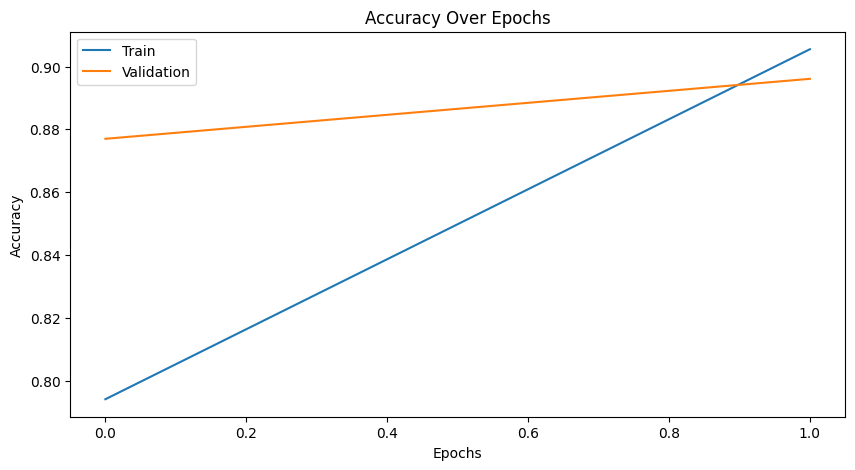

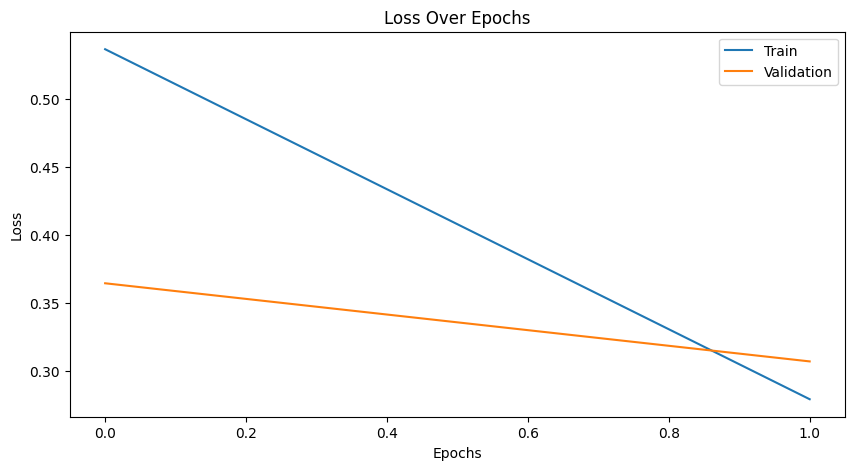

Test Loss: 0.3184788518530481, Test Accuracy: 0.8923684210526316
Confusion Matrix:
 [[1687   49   96   68]
 [  41 1806   28   25]
 [  74   15 1589  222]
 [  51   24  125 1700]]


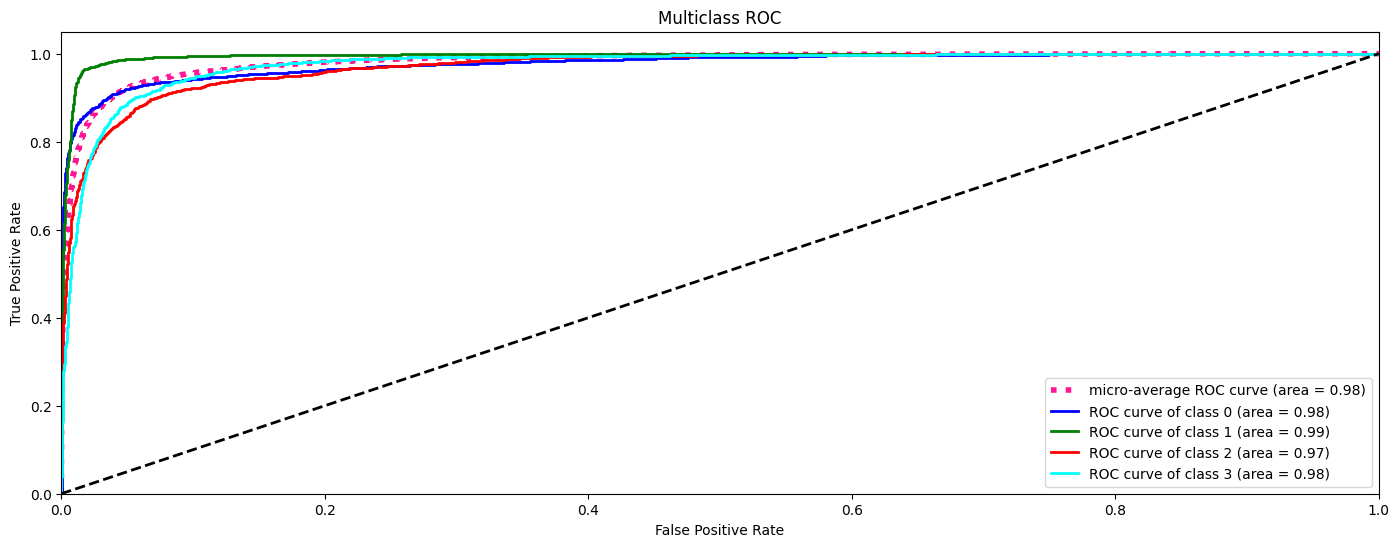

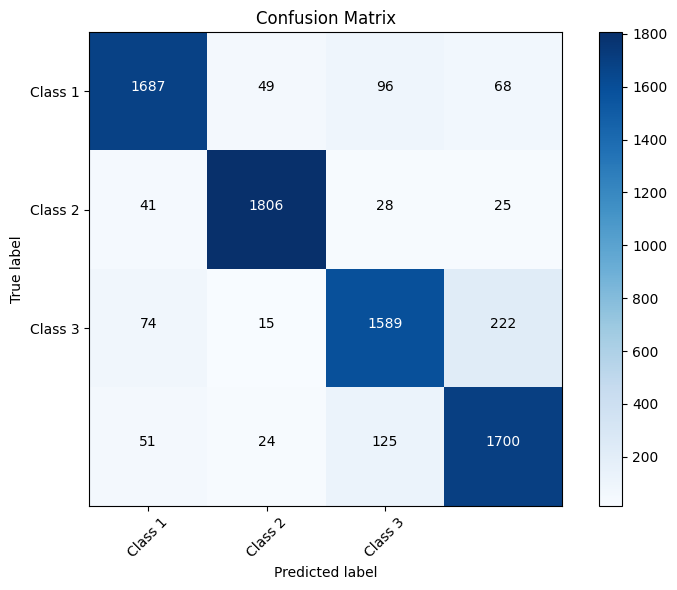

Precision: 0.893038036288061, Recall: 0.8923684210526316, F1 Score: 0.8924213924516552


In [4]:
# M1 Regularization
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001, weight_decay=1e-5)
best_model = train_and_evaluate(model_1, criterion, optimizer_1, train_loader, val_loader, test_loader, epochs=2)

In [6]:
# Model 2: Regularization + Dropout
class TransformerModelWithDropout(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=2, num_encoder_layers=2, embedding_dim=100, dropout=0.5):
        super(TransformerModelWithDropout, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.output_layer = nn.Linear(embedding_dim, num_classes)

    def forward(self, src):
        src = torch.nn.utils.rnn.pad_sequence(src, batch_first=True)
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        encoder_output = self.transformer_encoder(embedded)
        output = self.output_layer(encoder_output.mean(dim=1))
        return output

model_2 = TransformerModelWithDropout(input_dim, num_classes)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001, weight_decay=1e-5)

# Model 3: Regularization + Dropout + Different Learning Rate
model_3 = TransformerModelWithDropout(input_dim, num_classes)
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.0005, weight_decay=1e-5)  # Different learning rate

M2 Regularization + Dropout
Epoch 1, Train Loss: 0.6863320291770829, Train Accuracy: 0.7256018518518519, Validation Loss: 0.3886481960515181, Validation Accuracy: 0.8801666666666667
Epoch 2, Train Loss: 0.3839756075364572, Train Accuracy: 0.8708055555555556, Validation Loss: 0.31949206996957463, Validation Accuracy: 0.9015


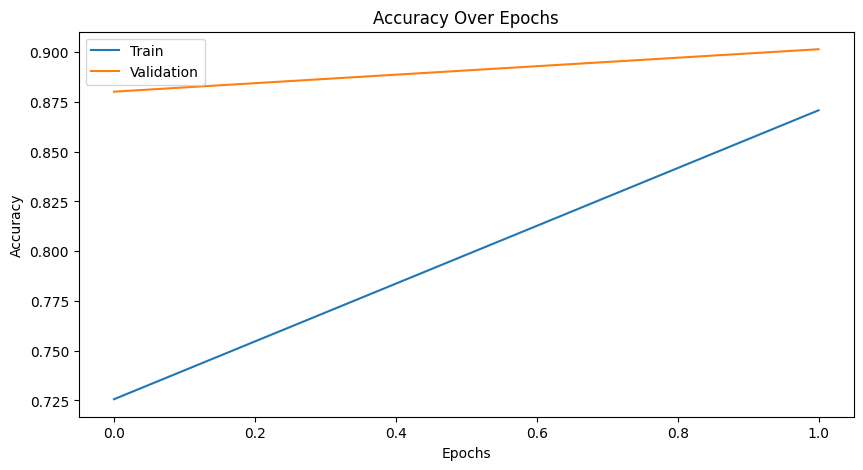

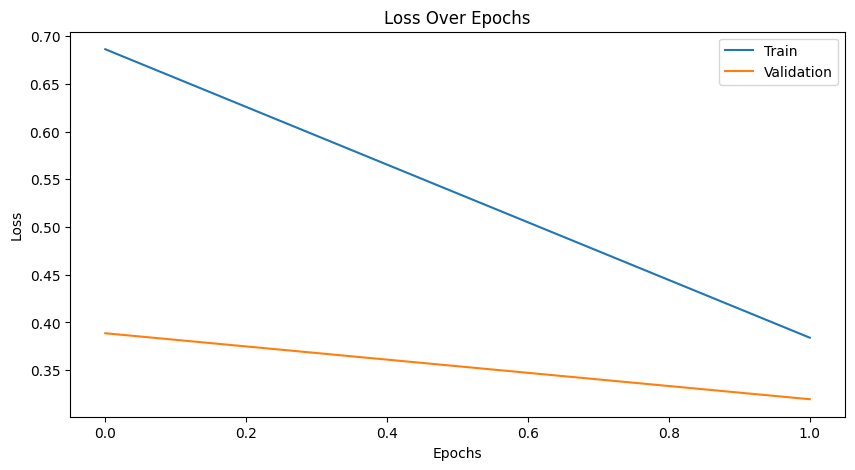

Test Loss: 0.3362168919201158, Test Accuracy: 0.8980263157894737
Confusion Matrix:
 [[1690   66   91   53]
 [  16 1856   16   12]
 [  71   20 1598  211]
 [  70   26  123 1681]]


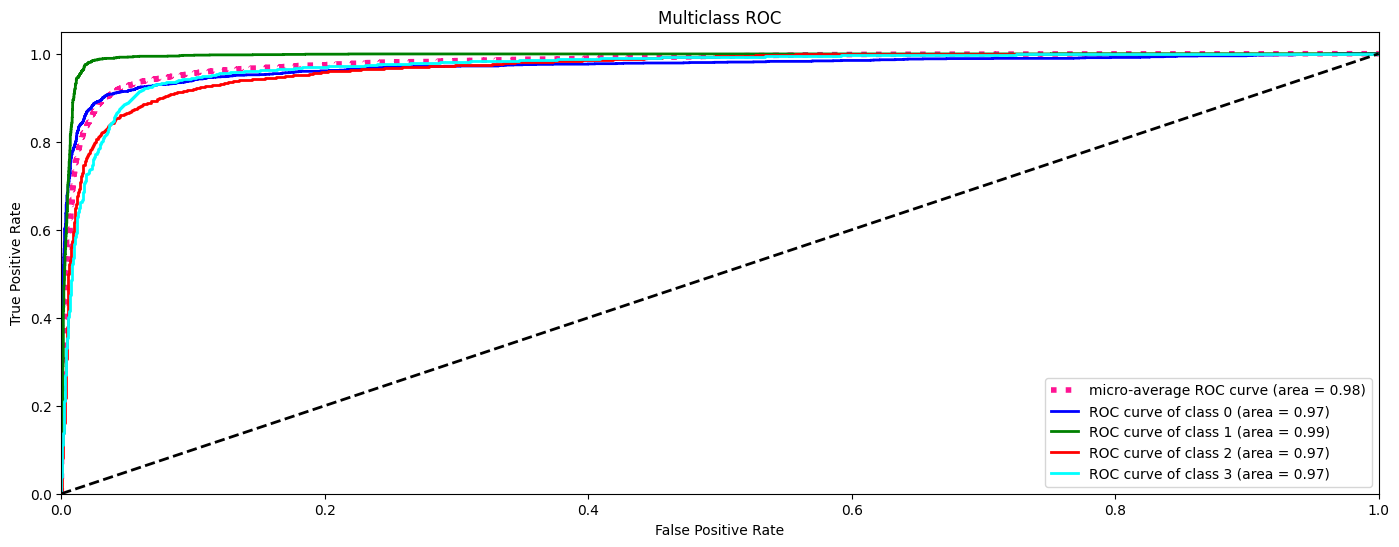

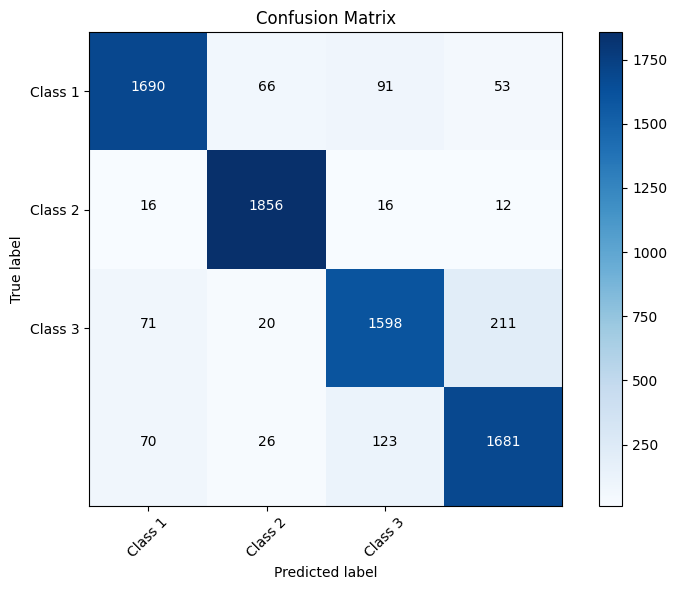

Precision: 0.8978084906857811, Recall: 0.8980263157894737, F1 Score: 0.8976705269215389


In [7]:
print("M2 Regularization + Dropout")

optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001, weight_decay=1e-5)
current_model = train_and_evaluate(model_2, criterion, optimizer_2, train_loader, val_loader, test_loader, epochs=2)
if current_model['val_loss'] < best_model['val_loss']:
    best_model = current_model



M3-egularization + Dropout + Different Learning Rate
Epoch 1, Train Loss: 0.8045914230699892, Train Accuracy: 0.669425925925926, Validation Loss: 0.44604517275094985, Validation Accuracy: 0.8456666666666667
Epoch 2, Train Loss: 0.461705972218955, Train Accuracy: 0.8345, Validation Loss: 0.32699527488152186, Validation Accuracy: 0.8901666666666667


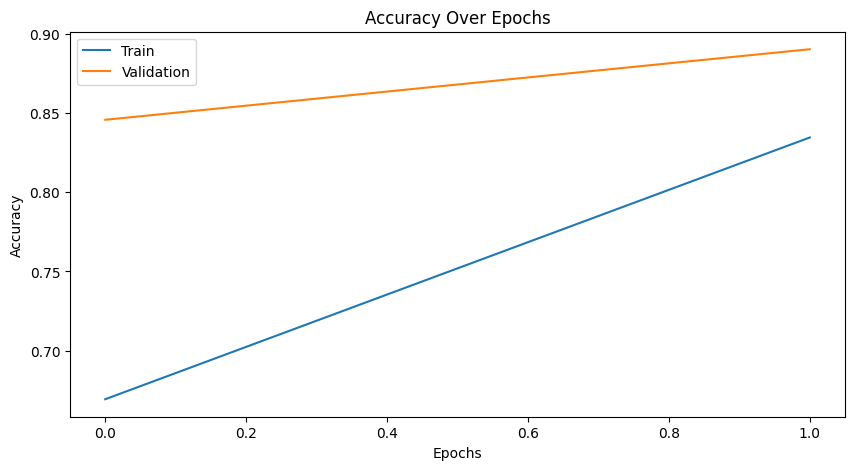

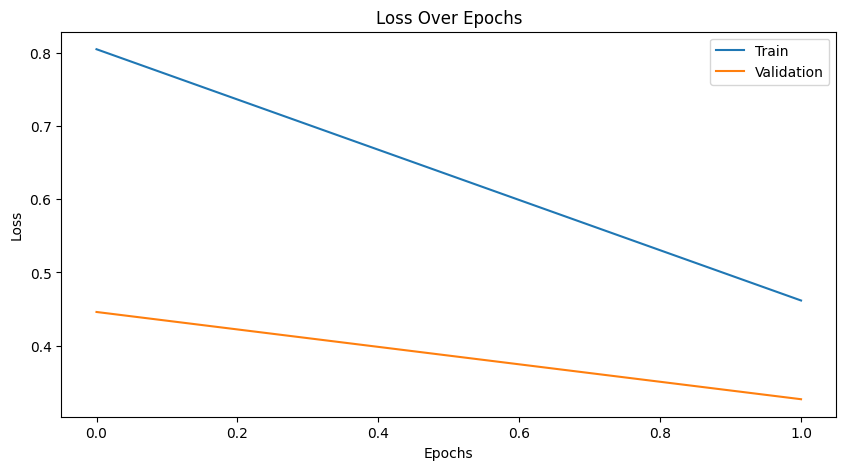

Test Loss: 0.3358473491643657, Test Accuracy: 0.8867105263157895
Confusion Matrix:
 [[1654   82  115   49]
 [  23 1838   25   14]
 [  73   27 1587  213]
 [  81   29  130 1660]]


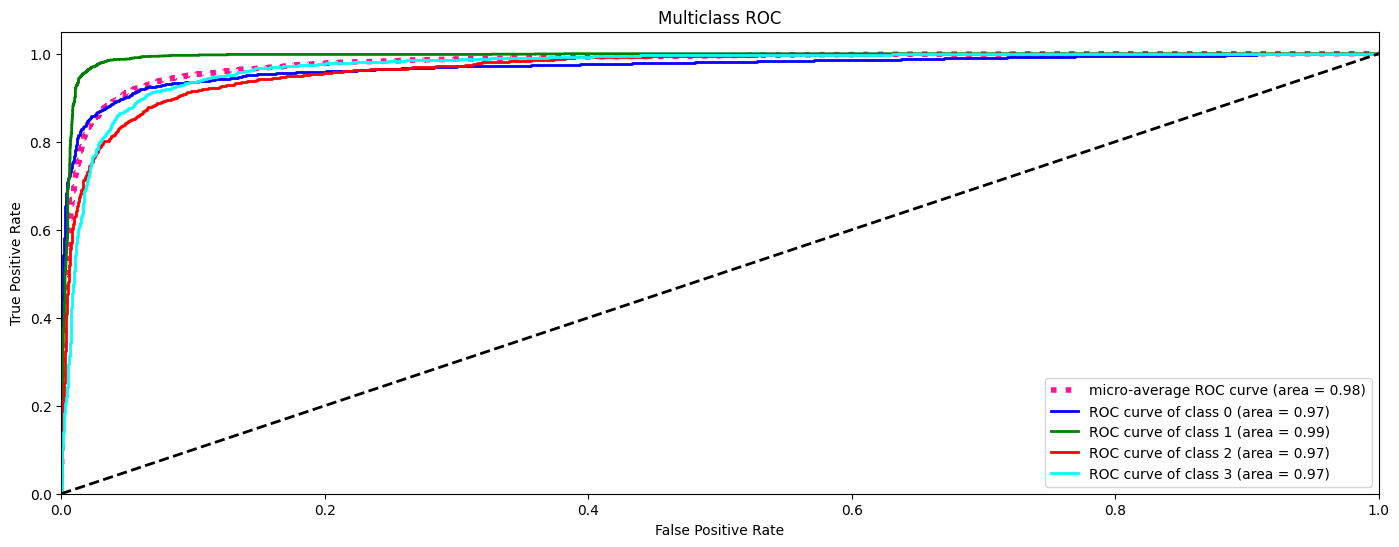

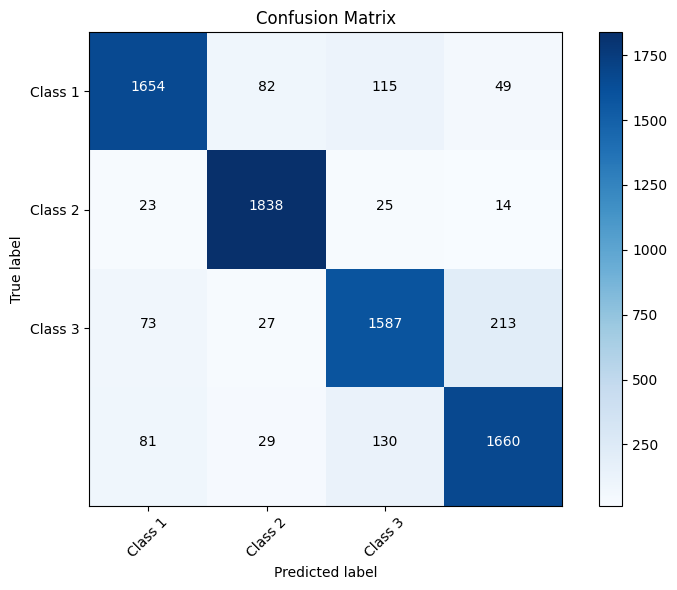

Precision: 0.8863839182515955, Recall: 0.8867105263157895, F1 Score: 0.8863334648761623


In [8]:
print("M3-egularization + Dropout + Different Learning Rate")
current_model = train_and_evaluate(model_3, criterion, optimizer_3, train_loader, val_loader, test_loader, epochs=2)
if current_model['val_loss'] < best_model['val_loss']:
    best_model = current_model

# References
- Dataset: https://webscope.sandbox.yahoo.com/catalog.php?datatype=s&did=70
- https://github.com/sushpatankar/Time-Series-Anomaly-Detection
- https://github.com/atuljha23/Anomaly-Detection-Using-ARIMA/blob/master/Anomaly%20Detection%20Using%20ARIMA%20and%20Linear%20Regression.ipynb
- https://keras.io/api/
- https://matplotlib.org/stable/users/index
